In [14]:
import pandas as pd
from konlpy.tag import Komoran, Kkma, Okt
import re
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from math import log
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt

tqdm.pandas()

In [3]:
def load_data():
    global data, stop_words, hotel_name

    data = pd.read_csv("../database/review_pseudolabeled.csv", encoding="utf-8")
    data = data[data["fixed"].notna()]

    with open("../vocab/kor_stop.txt", "r", encoding="utf-8") as f:
        list_file = f.readlines()
    stop_words = [line.rstrip("\n") for line in list_file]

    hotel_name = list(data.groupby("hotelName").count().index)

In [4]:
def tokenize(text):
    pos_tag = ["NNG", "NNP", "NNB", "NP", "NR", "VA", "MM", "MAG", "XR"]
    tokens_pos = komoran.pos(text)
    tokens_word = []
    for tag in tokens_pos:
        if tag[1] in pos_tag:
            if tag[0] not in stop_words:
                tokens_word.append(tag[0])

    return re.sub("\.", "", " ".join(tokens_word))

In [5]:
def preprocess():
    global data, komoran

    komoran = Komoran(userdic="../vocab/user_dic.txt")
    data["fixed"] = data["fixed"].progress_apply(lambda x: tokenize(x))

In [6]:
def get_term_frequency(document, word_dict=None):
    if word_dict is None:
        word_dict = {}
    words = document.split()

    for w in words:
        word_dict[w] = 1 + (0 if word_dict.get(w) is None else word_dict[w])

    return pd.Series(word_dict, dtype="float64").sort_values(ascending=False)

In [7]:
def get_document_frequency(documents):
    dicts = []
    vocab = set([])
    df = {}

    for d in documents:
        tf = get_term_frequency(d)
        dicts += [tf]
        vocab = vocab | set(tf.keys())

    for v in list(vocab):
        df[v] = 0
        for dict_d in dicts:
            if dict_d.get(v) is not None:
                df[v] += 1

    return pd.Series(df, name="df", dtype="float64").sort_values(ascending=False)

In [8]:
def get_tf(docs):
    vocab = {}
    tfs = []
    for d in docs:
        vocab = get_term_frequency(d, vocab)
        tfs += [get_term_frequency(d)]

    stats = []
    for word, freq in vocab.items():
        tf_v = []
        for idx in range(len(docs)):
            if tfs[idx].get(word) is not None:
                tf_v += [tfs[idx][word]]
            else:
                tf_v += [0]
        stats.append((word, freq, *tf_v))

    column_name = ["word", "totalFrequency"]
    for i in range(1, len(docs) + 1):
        column_name.append("document" + str(i))

    return pd.DataFrame(stats, columns=column_name).sort_values("totalFrequency", ascending=False)

In [9]:
def get_ntf(matrix):
    max_btf = max(matrix["totalFrequency"])
    total_btf = sum(matrix["totalFrequency"])
    col_names = list(matrix.columns)[2:]
    matrix["ntf1"] = matrix["totalFrequency"].apply(lambda x: x / max_btf)

    matrix_ntf2 = matrix[col_names].copy()
    matrix_ntf2 = matrix_ntf2.apply(lambda x: x / total_btf, axis=1)
    matrix_ntf2["ntf2"] = matrix_ntf2.apply(sum, axis=1)
    matrix["ntf2"] = matrix_ntf2["ntf2"]

    return matrix[["word", "totalFrequency", "ntf1", "ntf2"]]

In [10]:
def get_ntf_idf(ntf, df, document_count):
    ntf = ntf.set_index("word")
    ntf_idf = pd.concat([ntf, df], axis=1)

    def get_ntf1idf(scores):
        return (np.log(scores["ntf1"]) + 1.0) * np.log(document_count / scores["df"])

    ntf_idf["ntf1_idf"] = ntf_idf.apply(get_ntf1idf, axis=1)
    ntf1_rank = ntf_idf["ntf1_idf"].sort_values(ascending=False)

    return ntf1_rank

In [11]:
def save_keywords(label: int):
    for h_name in tqdm(hotel_name):
        data1 = data[data["hotelName"] == h_name]
        data2 = data1[data1["label"] == label]
        docs = data2["fixed"].to_list()

        document_count = len(docs)
        tf_matrix = get_tf(docs)
        df_matrix = get_document_frequency(docs)
        ntf_matrix = get_ntf(tf_matrix)

        ntf1_rank = get_ntf_idf(ntf_matrix, df_matrix, document_count)
        if label == 0:
            ntf1_rank.to_csv("../keywords/ntf1_" + h_name + "_neg.csv", encoding="utf-8")
        else:
            ntf1_rank.to_csv("../keywords/ntf1_" + h_name + "_pos.csv", encoding="utf-8")

In [11]:
load_data()
preprocess()
save_keywords(label=0)

100%|██████████| 38/38 [05:51<00:00,  9.24s/it]


In [12]:
load_data()
preprocess()
save_keywords(label=1)

100%|██████████| 38/38 [15:47<00:00, 24.94s/it]


In [12]:
load_data()
preprocess()

fixed_words = []
h_name = "페어필드 바이 메리어트 서울"
data_h = data[data["hotelName"] == h_name]
for i in range(len(data_h["fixed"])):
    if len(data["fixed"][i]) > 0:
        fixed_words.append(data["fixed"][i].split())

top_neg_keywords = {"소리": 0, "화장실": 0, "소음": 0, "주차비": 0, "기차": 0}
for k, v in top_neg_keywords.items():
    for j in range(len(fixed_words)):
        top_neg_keywords[k] += fixed_words[j].count(k)

top_pos_keywords = {"깨끗": 0, "깔끔": 0, "친절": 0, "만족": 0, "위치": 0}
for k, v in top_pos_keywords.items():
    for j in range(len(fixed_words)):
        top_pos_keywords[k] += fixed_words[j].count(k)

print(top_neg_keywords)
print(top_pos_keywords)

100%|██████████| 154031/154031 [01:24<00:00, 1819.25it/s]


{'소리': 428, '화장실': 363, '소음': 336, '주차비': 291, '기차': 278}
{'깨끗': 1382, '깔끔': 1093, '친절': 787, '만족': 568, '위치': 416}


In [35]:
font_name = "NanumGothicCoding" 
matplotlib.rc('font', family=font_name)
%matplotlib inline

plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams['font.size'] = 12.
plt.rcParams['xtick.labelsize'] = 12.
plt.rcParams['ytick.labelsize'] = 12.
plt.rcParams['axes.labelsize'] = 12.

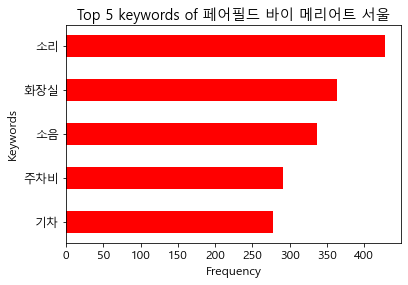

In [37]:
plt.barh(list(reversed(list(top_neg_keywords.keys()))), list(reversed(list(top_neg_keywords.values()))), color="red", height=0.5)
plt.title("Top 5 keywords of 페어필드 바이 메리어트 서울")
plt.xlabel("Frequency")
plt.ylabel("Keywords")
plt.show()

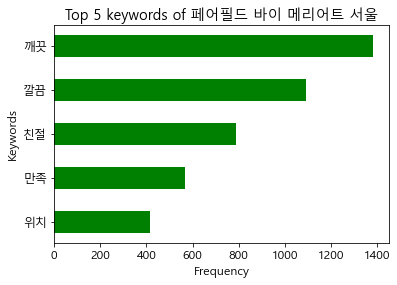

In [38]:
plt.barh(list(reversed(list(top_pos_keywords.keys()))), list(reversed(list(top_pos_keywords.values()))), color="green", height=0.5)
plt.title("Top 5 keywords of 페어필드 바이 메리어트 서울")
plt.xlabel("Frequency")
plt.ylabel("Keywords")
plt.show()